In [1]:
import os 
from Bio import SeqIO
import pickle
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import math

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 10
expName = "Test_Run_current_setting2"
outPath = "Generated"
foldName = "folds.pickle"

modelNames = ["DLNN_CORENup"]

epochs=200
batch_size = 64
shuffle = False
seed = None

dataset_path = "CORENup-Datasets\\Datasets"
setting = "Setting2"


In [4]:
##################################################################################
##### Checking the directory
##################################################################################

dataset_setting_path = os.path.join(dataset_path, setting)
dataset_varieties = next(os.walk(dataset_setting_path))
print(dataset_varieties)

('CORENup-Datasets\\Datasets\\Setting2', ['Drosophila', 'Homo_Sapiens', 'Yeast'], [])


In [5]:
##################################################################################
##### define custom one hot encoding, contains code from repository
##################################################################################

def one_hot_encode(sequence):
    
    seq_encoded = np.zeros((len(sequence),4))
    dict_nuc = {
        "A": 0,
        "C": 1,
        "G": 2,
        "T":3
    }
    i = 0
    
    for single_character in sequence:
        if(single_character.upper() in dict_nuc.keys()):
            seq_encoded[i][dict_nuc[single_character.upper()]] = 1
            i = i+1
        else:
            return []
    
    return seq_encoded

In [6]:
##################################################################################
##### Function to customize the DLNN CORENup network architecture with parameters
##################################################################################

def DLNN_CORENup(input_shape = (150,4),
                 conv_filters_per_layer_1 = 50, kernel_length_1 = 5, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
                 lstm_decode_units = 50, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 50,  kernel_length_2 = 10, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
                 dense_decode_units = 370, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None):
    
    beta = 0.001
    
    input1 = tf.keras.layers.Input(shape=input_size)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1, input_shape = input_shape, 
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              dropout=0.1)(x1)
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## LSTM Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)

    ## Fully connected Layers

    y = tf.keras.layers.Concatenate(1)([x2,x3])
    
    y1 = tf.keras.layers.Dense(dense_decode_units, kernel_regularizer = tf.keras.regularizers.l2(beta), activation = 'relu')(y)
    
    y1 = tf.keras.layers.Dropout(prob)(y1)
    
    y1 = tf.keras.layers.Dense(1, kernel_regularizer = tf.keras.regularizers.l2(beta), activation = 'sigmoid')(y1)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=[input1], outputs=y1)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr=learn_rate), loss = loss)

    return model

In [7]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

In [8]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Kernel_Length" : [],
    "Dataset" : [],
    "Sub_Category" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        if("_vs_" in file):
            
            current_dataset_variety = root.split("\\")[len(root.split("\\"))-2]
            current_dataset_variety_subcategory = root.split("\\")[len(root.split("\\"))-1]
            
            ##################################################################################
            ##### read the current file
            ##################################################################################
            
            openFile = open(os.path.join(root,file))
            fastaSequences = SeqIO.parse(openFile, "fasta")
            
            ##################################################################################
            ##### extract data from the current fasta file
            ##################################################################################
            
            nucleosomal_List = []
            linker_List = []
            nucleosomal_onehotencoded_List = []
            linker_onehotencoded_List = []
            
            for fasta in fastaSequences: 
                name, sequence = fasta.id, str(fasta.seq)
                if "nucleosomal" in name:
                    nucleosomal_List.append(sequence)
                    aus_seq = one_hot_encode(sequence)
                    if(len(aus_seq) != 0):
                        nucleosomal_onehotencoded_List.append(aus_seq)
                else:
                    linker_List.append(sequence)
                    aus_seq = one_hot_encode(sequence)
                    if(len(aus_seq) != 0):
                        linker_onehotencoded_List.append(aus_seq)
            
            print("\n======================================================================")
            print("\nFile: "+os.path.join(root, file))
            print("Nucleosomi: "+str(len(nucleosomal_onehotencoded_List)))
            print("Linker: "+str(len(linker_onehotencoded_List)))
            
            ##################################################################################
            ##### Generate Folds from dataset, and store to file
            ##################################################################################
            
            ## create the features and labels datasets for the training
            input_size = (len(nucleosomal_onehotencoded_List[1]), 4)
            labels = np.concatenate((np.ones((len(nucleosomal_onehotencoded_List), 1), dtype=np.float32), np.zeros((len(linker_onehotencoded_List), 1), dtype=np.float32)), axis=0)
            features = np.concatenate((nucleosomal_onehotencoded_List,linker_onehotencoded_List), 0)

            ## Generate the k-fold dataset
            folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
            
            ## Write the k-fold dataset to file
            foldPath = os.path.join(outPath, expName, current_dataset_variety, current_dataset_variety_subcategory, "{}fold".format(n_fold))
            
            ##### ADDITIONAL CHANGES - USE PREVIOUS GENERATED FOLDS IF AVAILABLE
        
            if(os.path.isfile(os.path.join(foldPath, foldName))):
                folds = pickle.load(open(os.path.join(foldPath, foldName), "rb"))
            else:
                if(not os.path.isdir(foldPath)):
                    os.makedirs(foldPath)
                pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
            
            ##################################################################################
            ##### TRAIN and PREDICT for every Fold, using both models (DLNN3 and DLNN5)
            ##################################################################################

            for modelName in modelNames:

                ## Create and set directory to save model
                modelPath = os.path.join(outPath, expName, current_dataset_variety, current_dataset_variety_subcategory, 
                                         "{}fold".format(n_fold), "models", modelName)
                if(not os.path.isdir(modelPath)):
                    os.makedirs(modelPath)

                # fold counter
                i = 0

                for fold in folds:

                    print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")

                    ## Generate model using function
                    model = DLNN_CORENup(input_shape = input_size)

                    ## Define the model callbacks for early stopping and saving the model. Then train model
                    modelCallbacks = [
                        tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_bestModel-fold{}.hdf5".format(modelName, i)),
                                                           monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                         mode = 'auto', baseline = None, restore_best_weights = False)
                    ]
                    model.fit(x = fold["X_train"], y = fold["y_train"], batch_size = batch_size, epochs = epochs, verbose = 0, 
                              callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))

                    ##################################################################################
                    ##### Prediction and metrics for TRAIN dataset
                    ##################################################################################

                    y_pred = model.predict(fold["X_train"])
                    label_pred = pred2label(y_pred)
                    # Compute precision, recall, sensitivity, specifity, mcc
                    acc = accuracy_score(fold["y_train"], label_pred)
                    prec = precision_score(fold["y_train"],label_pred)

                    conf = confusion_matrix(fold["y_train"], label_pred)
                    if(conf[0][0]+conf[1][0]):
                        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                    else:
                        sens = 0.0
                    if(conf[1][1]+conf[0][1]):
                        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                    else:
                        spec = 0.0
                    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                    else:
                        mcc= 0.0
                    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                    auc = roc_auc_score(fold["y_train"], y_pred)

                    evaluations["Model"].append(modelName)
                    evaluations["Kernel_Length"].append("5,10")
                    evaluations["Dataset"].append(current_dataset_variety)
                    evaluations["Sub_Category"].append(current_dataset_variety_subcategory)
                    evaluations["Fold"].append(i)
                    evaluations["Train_Test"].append("Train")
                    evaluations["Accuracy"].append(acc)
                    evaluations["Precision"].append(prec)
                    evaluations["TPR"].append(tpr)
                    evaluations["FPR"].append(fpr)
                    evaluations["TPR_FPR_Thresholds"].append(thresholds)
                    evaluations["AUC"].append(auc)
                    evaluations["Sensitivity"].append(sens)
                    evaluations["Specificity"].append(spec)
                    evaluations["MCC"].append(mcc)

                    ##################################################################################
                    ##### Prediction and metrics for TEST dataset
                    ##################################################################################

                    y_pred = model.predict(fold["X_test"])
                    label_pred = pred2label(y_pred)
                    # Compute precision, recall, sensitivity, specifity, mcc
                    acc = accuracy_score(fold["y_test"], label_pred)
                    prec = precision_score(fold["y_test"],label_pred)

                    conf = confusion_matrix(fold["y_test"], label_pred)
                    if(conf[0][0]+conf[1][0]):
                        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                    else:
                        sens = 0.0
                    if(conf[1][1]+conf[0][1]):
                        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                    else:
                        spec = 0.0
                    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                    else:
                        mcc= 0.0
                    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                    auc = roc_auc_score(fold["y_test"], y_pred)

                    evaluations["Model"].append(modelName)
                    evaluations["Kernel_Length"].append("5,10")
                    evaluations["Dataset"].append(current_dataset_variety)
                    evaluations["Sub_Category"].append(current_dataset_variety_subcategory)
                    evaluations["Fold"].append(i)
                    evaluations["Train_Test"].append("Test")
                    evaluations["Accuracy"].append(acc)
                    evaluations["Precision"].append(prec)
                    evaluations["TPR"].append(tpr)
                    evaluations["FPR"].append(fpr)
                    evaluations["TPR_FPR_Thresholds"].append(thresholds)
                    evaluations["AUC"].append(auc)
                    evaluations["Sensitivity"].append(sens)
                    evaluations["Specificity"].append(spec)
                    evaluations["MCC"].append(mcc)

                    i = i+1
                    del model
                    tf.keras.backend.clear_session()

##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "wb"))




File: CORENup-Datasets\Datasets\Setting2\Drosophila\5UTR\nucleosomes_vs_linkers_drosophila_5u.fas
Nucleosomi: 4669
Linker: 2704

Train/Test model DLNN_CORENup on Fold #0.

Train/Test model DLNN_CORENup on Fold #1.

Train/Test model DLNN_CORENup on Fold #2.

Train/Test model DLNN_CORENup on Fold #3.

Train/Test model DLNN_CORENup on Fold #4.

Train/Test model DLNN_CORENup on Fold #5.

Train/Test model DLNN_CORENup on Fold #6.

Train/Test model DLNN_CORENup on Fold #7.

Train/Test model DLNN_CORENup on Fold #8.

Train/Test model DLNN_CORENup on Fold #9.


File: CORENup-Datasets\Datasets\Setting2\Drosophila\Longest_chr\nucleosomes_vs_linkers_drosophila_lc.fas
Nucleosomi: 46054
Linker: 30458

Train/Test model DLNN_CORENup on Fold #0.

Train/Test model DLNN_CORENup on Fold #1.

Train/Test model DLNN_CORENup on Fold #2.

Train/Test model DLNN_CORENup on Fold #3.

Train/Test model DLNN_CORENup on Fold #4.

Train/Test model DLNN_CORENup on Fold #5.

Train/Test model DLNN_CORENup on Fold #6.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #1.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #2.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #3.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #4.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #5.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #6.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #7.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #8.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model DLNN_CORENup on Fold #9.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in longlong_scalars




File: CORENup-Datasets\Datasets\Setting2\Homo_Sapiens\Promoter\nucleosomes_vs_linkers_human_prom.fas
Nucleosomi: 56403
Linker: 44441

Train/Test model DLNN_CORENup on Fold #0.

Train/Test model DLNN_CORENup on Fold #1.

Train/Test model DLNN_CORENup on Fold #2.

Train/Test model DLNN_CORENup on Fold #3.

Train/Test model DLNN_CORENup on Fold #4.

Train/Test model DLNN_CORENup on Fold #5.

Train/Test model DLNN_CORENup on Fold #6.

Train/Test model DLNN_CORENup on Fold #7.

Train/Test model DLNN_CORENup on Fold #8.

Train/Test model DLNN_CORENup on Fold #9.


File: CORENup-Datasets\Datasets\Setting2\Yeast\Promoter\nucleosomes_vs_linkers_yeast_prom.fas
Nucleosomi: 27373
Linker: 4463

Train/Test model DLNN_CORENup on Fold #0.

Train/Test model DLNN_CORENup on Fold #1.

Train/Test model DLNN_CORENup on Fold #2.

Train/Test model DLNN_CORENup on Fold #3.

Train/Test model DLNN_CORENup on Fold #4.

Train/Test model DLNN_CORENup on Fold #5.

Train/Test model DLNN_CORENup on Fold #6.

Train/

FileNotFoundError: [Errno 2] No such file or directory: 'Generated\\Test_Run_current_setting2\\_Evaluation_All_Datasets\\10fold_evaluations_DLNN_CORENup.pickle'

## Visualization of Evaluation

In [19]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import math
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd


In [20]:
##################################################################################
##### Parameters used only in this section
##################################################################################

n_fold = 10
expName = "Test_Run_current_setting2"
outPath = "Generated"

modelNames = ["DLNN_CORENup"]

In [21]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [22]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset",
                                                 "Sub_Category",
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

DLNN_CORENup_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Train'])]
DLNN_CORENup_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Test'])]

In [23]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ")
print(list(evaluations_df_grouped.columns))

Metrics Available : 
['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [24]:
metric_to_plot = "Accuracy"

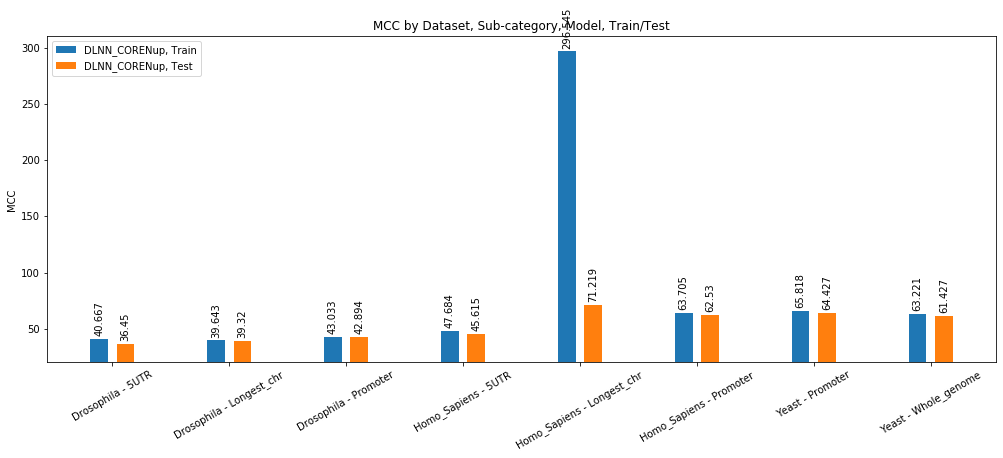

In [27]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(DLNN_CORENup_Train[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(x - (1.5*(width/2)), round(DLNN_CORENup_Train[metric_to_plot]*100, 3), width, label='DLNN_CORENup, Train')
rects3 = ax.bar(x + (1.5*(width/2)), round(DLNN_CORENup_Test[metric_to_plot]*100, 3), width, label='DLNN_CORENup, Test')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
            (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
# ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
ax.set_xticklabels([m+" - "+str(n) for m,n in 
                        zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
                  rotation=30)

ax.set_title(metric_to_plot+' by Dataset, Sub-category, Model, Train/Test')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects3)

plt.show()

### Store all metrics' plots to file

In [28]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    x = np.arange(len(DLNN_CORENup_Train[metric_to_plot]))
    width = 0.15

    fig, ax = plt.subplots(figsize=(17,6))
    rects1 = ax.bar(x - (1.5*(width/2)), round(DLNN_CORENup_Train[metric_to_plot]*100, 3), width, label='DLNN_3, Train')
    rects3 = ax.bar(x + (1.5*(width/2)), round(DLNN_CORENup_Test[metric_to_plot]*100, 3), width, label='DLNN_3, Test')

    ## Custom y-axis tick labels
    ax.set_ylabel(metric_to_plot)
    ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
                (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
    # ax.set_ylim([80, 105])

    ## Custom x-axis tick labels
    ax.set_xticks(x)
    # ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
    ax.set_xticklabels([m+" - "+str(n) for m,n in 
                            zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
                      rotation=30)

    ax.set_title(metric_to_plot+' by Dataset, Sub-category, Model, Train/Test')
    ax.legend(loc='upper left')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", 
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects3)
    
    plt.savefig(os.path.join(evalPath, "{}_{}_Comparison".format(metric_to_plot, modelNames[0])))
    plt.close()
    